In [1]:
import geopandas as gp
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AffinityPropagation
import matplotlib.pyplot as plt
import seaborn as sns
from shapely import MultiPoint
import math
import osmnx
import networkx as nx 

In [2]:
tours = pd.read_csv("./data/tours.csv")

In [3]:
user_counts = tours.groupby("user_id").count()['latitude']
user_counts[user_counts > 1].shape


(3915,)

In [4]:
raw_tours = gp.GeoDataFrame(tours, geometry=gp.points_from_xy(tours.longitude, tours.latitude), crs="epsg:4326")

In [5]:
clean_tours = tours.groupby("user_id").median()

In [6]:
clean_tours = gp.GeoDataFrame(clean_tours, geometry=gp.points_from_xy(clean_tours.longitude, clean_tours.latitude), crs="epsg:4326")

<Axes: title={'center': 'After duplicate removal'}>

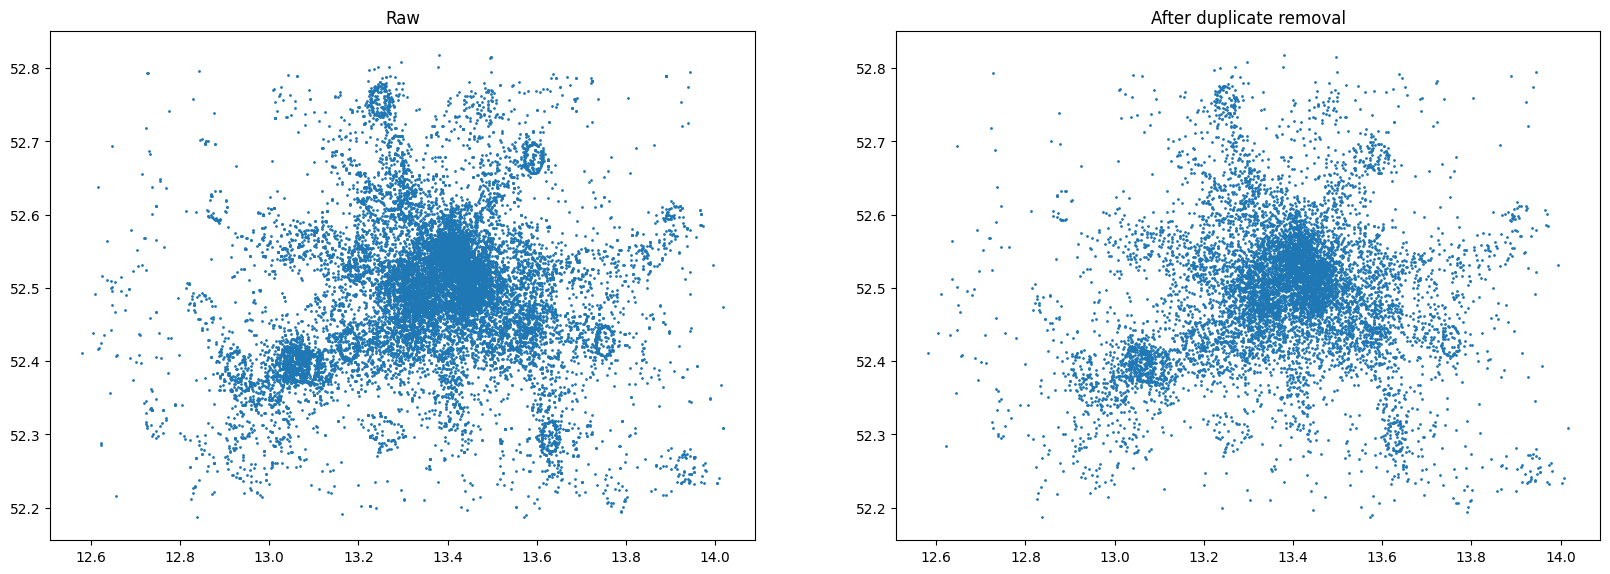

In [7]:
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax1.set_title("Raw")
ax2.set_title("After duplicate removal")

raw_tours.plot(ax=ax1, markersize=1)
clean_tours.plot(ax=ax2, markersize=1)

In [64]:
clean_tours.to_file("clean_tours.geojson",driver="GeoJSON")

In [8]:
crs = clean_tours.estimate_utm_crs()

In [9]:
clean_tours = clean_tours.to_crs(crs)

In [10]:
def generate_hull(df):
    print(df.columns)
    hulls= df.groupby('label').apply(lambda group: gp.GeoSeries(MultiPoint(group.geometry).convex_hull)).rename(columns={0:"geometry"}).reset_index(drop=True)
    return gp.GeoDataFrame(hulls, crs=df.crs)

In [11]:
def plot_clusters(df):
    cluster_counts = df.label.value_counts()
    colors = sns.color_palette(n_colors=cluster_counts.shape[0])
    convex_hulls = generate_hull(df)
    fig,(ax1,ax2) = plt.subplots(nrows=2, ncols=1,figsize=(20,35))
    convex_hulls.plot(ax=ax1, facecolor="none")
    df.plot(ax=ax1, c = df.label.apply(lambda label: colors[label]), markersize=2)
    cluster_counts.hist(bins=20,ax=ax2)


In [12]:
def try_clustering(clustAlgo, df):
    clusters = clustAlgo.fit(np.array( list(zip(df.geometry.x, df.geometry.y))))
    return df.assign(label=clusters.labels_)


In [13]:
def split_clusters(df,max_occupancy=40):
    cluster_value_counts = df.label.value_counts()
    clusters_to_split = cluster_value_counts[cluster_value_counts>40].index
    split_clusters= df.copy()
    for cluster_label_to_split in clusters_to_split:
        target_cluster = df[df.label == cluster_label_to_split]
        target_no_splits = math.ceil( target_cluster.shape[0] / max_occupancy);
        sub_cluster = try_clustering(KMeans(n_clusters= target_no_splits, n_init='auto'), target_cluster)
        max_existing_label = split_clusters.label.max()
        sub_cluster.label = sub_cluster.label + max_existing_label + 1 
        split_clusters = gp.GeoDataFrame(pd.concat([split_clusters[split_clusters.label != cluster_label_to_split], sub_cluster], axis=0))
    unique_labels = split_clusters.label.drop_duplicates().sort_values().values
    label_remap = dict(zip(unique_labels, range(0,unique_labels.shape[0])))
    split_clusters.label = split_clusters.label.apply(lambda old_label: label_remap[old_label])
    return split_clusters

In [14]:
def splt_clusters_until_threshold(df, max_occupancy=40, max_iters=10):
    fully_split_df = df.copy()
    for i in range(0,10):
        print("Iteration ", i)
        fully_split_df = split_clusters(fully_split_df, max_occupancy)
        if( not (fully_split_df.label.value_counts() > max_occupancy).any()):
            return fully_split_df
    return fully_split_df
        
        

In [15]:
clusters = try_clustering(AffinityPropagation(damping=0.95),clean_tours)

In [16]:
new_clusters = splt_clusters_until_threshold(clusters)

Iteration  0
Iteration  1


Index(['latitude', 'longitude', 'geometry', 'label'], dtype='object')


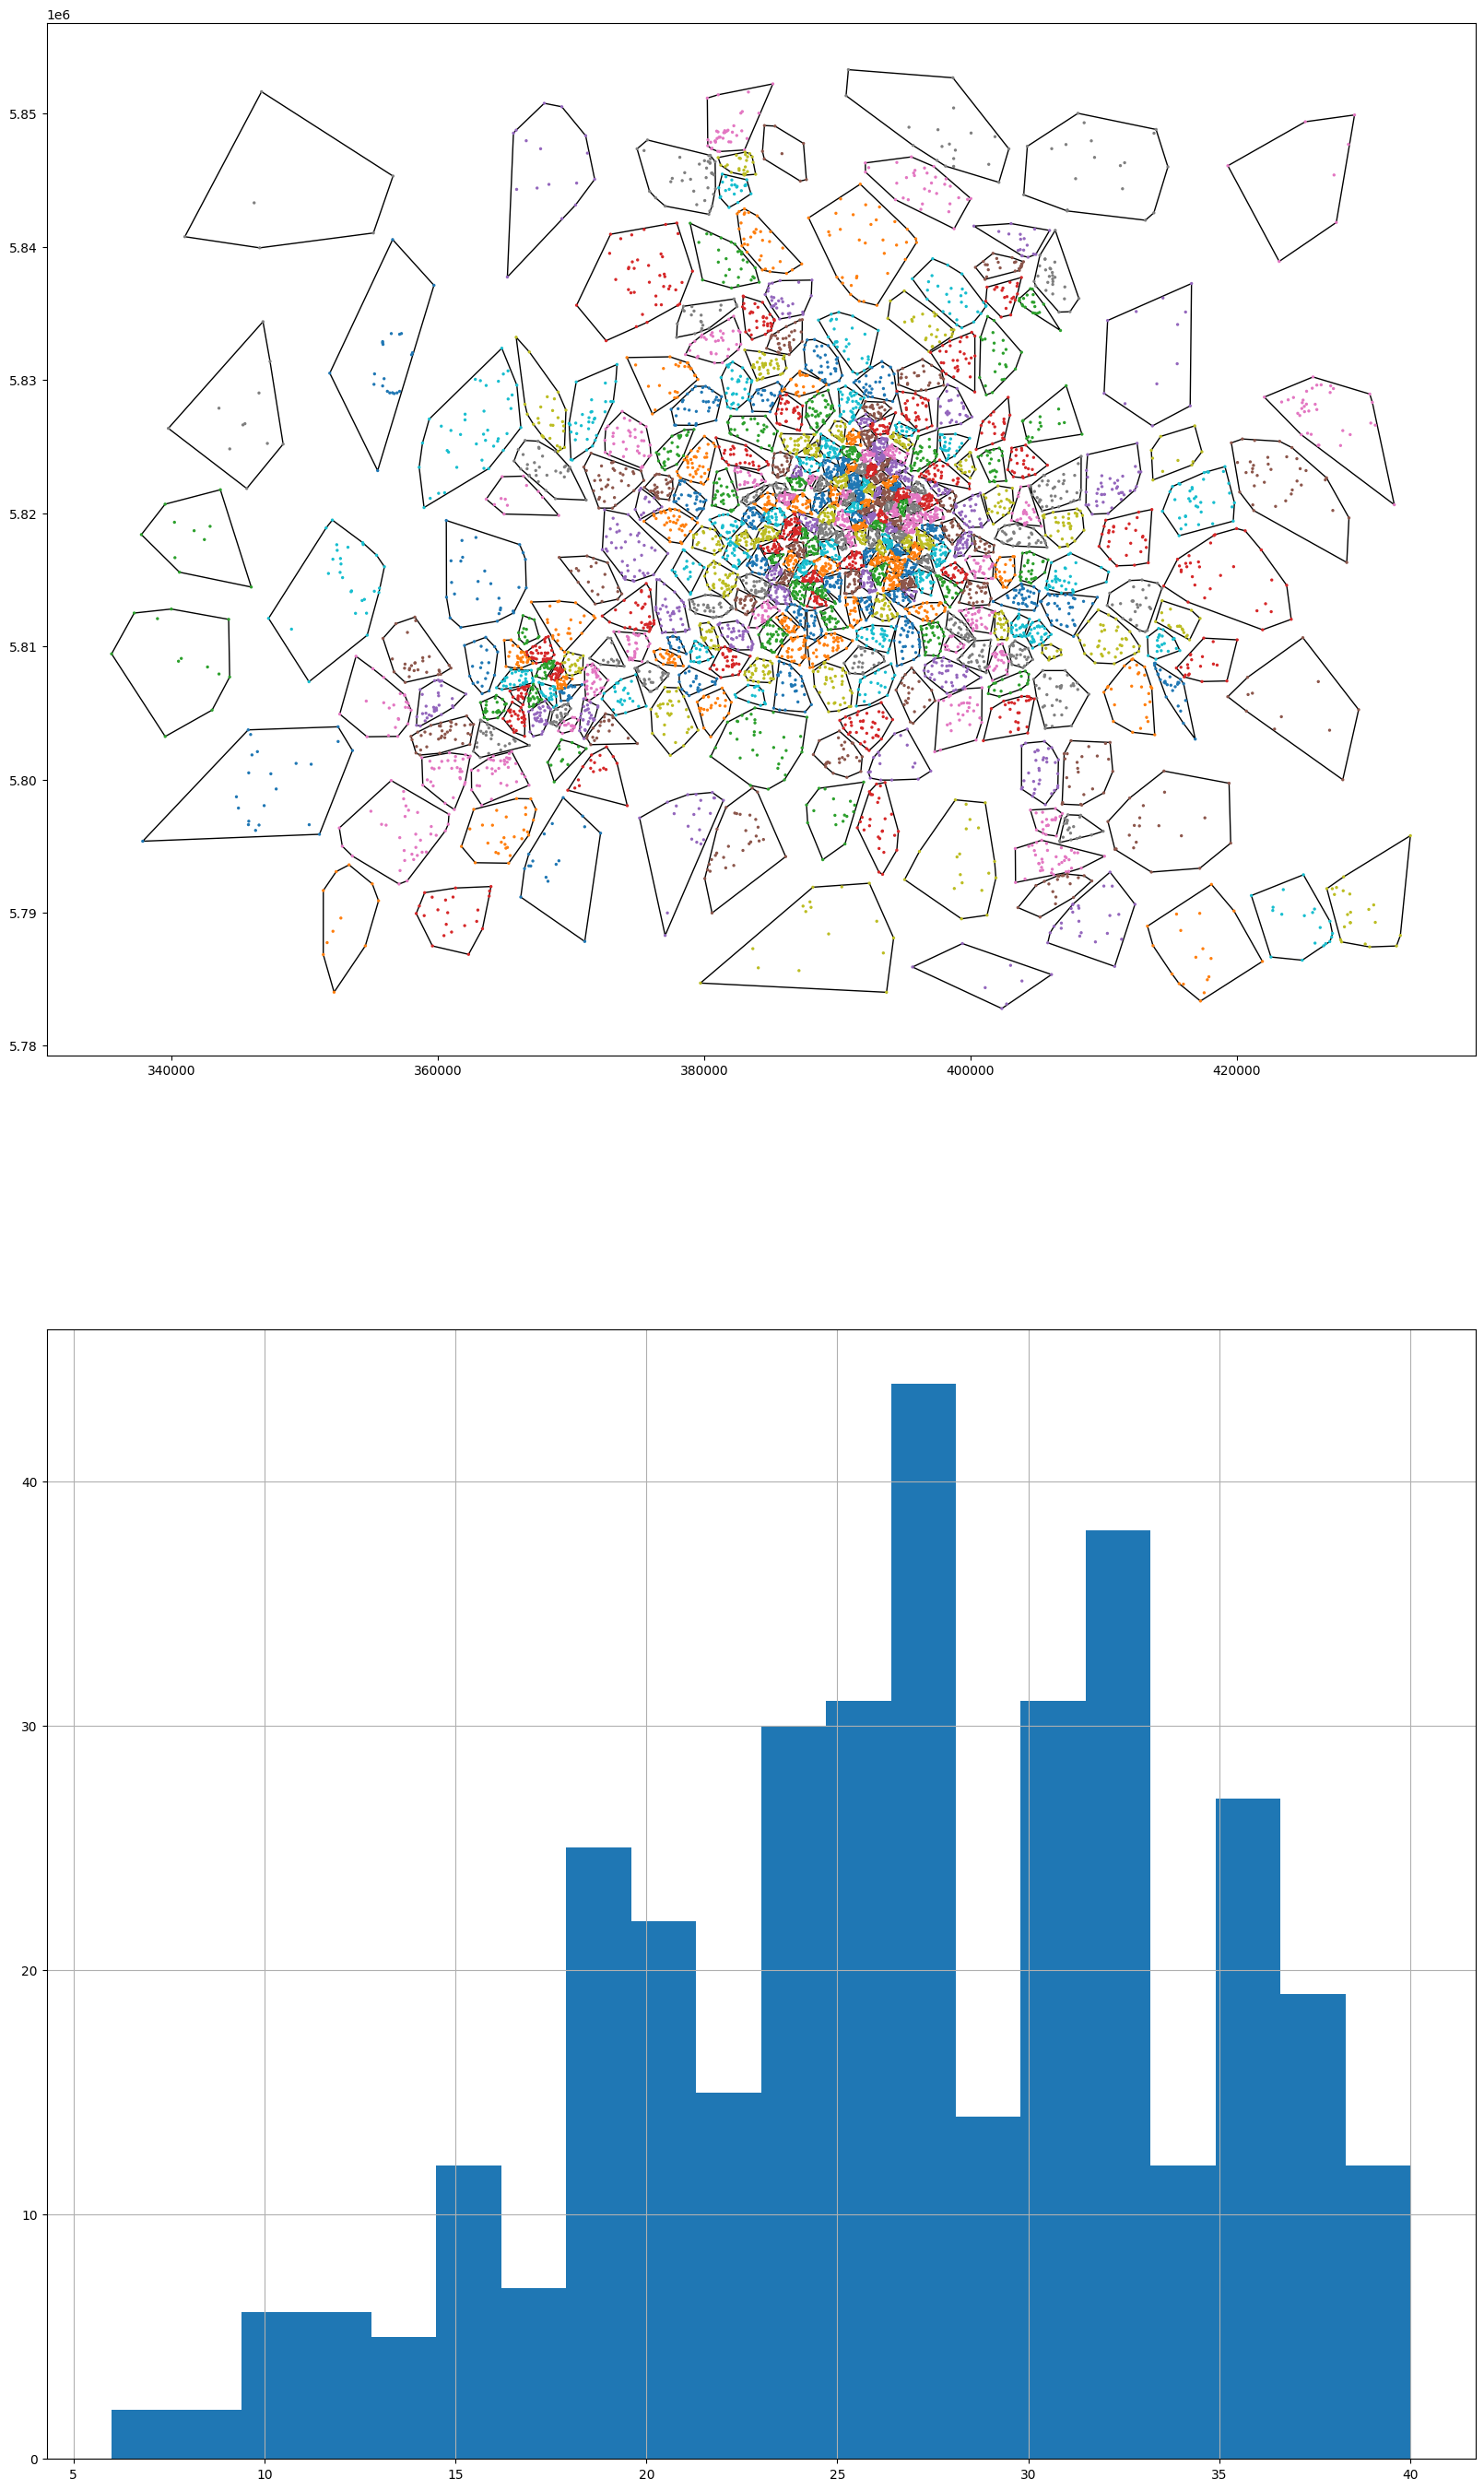

In [17]:
plot_clusters(new_clusters)

In [18]:
    cluster_centroids = gp.GeoSeries(clusters.groupby("label").apply(lambda group: MultiPoint(group.geometry).centroid))

In [7]:
bounds = clean_tours.to_crs("epsg:4326").total_bounds

In [8]:
graph = osmnx.graph_from_bbox(bounds[3], bounds[1], bounds[2], bounds[0], network_type="bike")

In [14]:
osmnx.nearest_nodes(graph, [13.6075648], [52.3740121])

[21432146]

In [12]:
graph.nodes(data=True)[21432146]

{'y': 52.3740121, 'x': 13.6075648, 'street_count': 3}

In [23]:
projected_graph = osmnx.project_graph(graph, to_crs=crs)

In [37]:
def bike_distances_to_centroids(graph, df, cluster_centroids):
    centroids_node_list = osmnx.nearest_nodes(projected_graph,cluster_centroids.x, cluster_centroids.y)
    points_node_list, distance_to_node = osmnx.nearest_nodes(graph,df.geometry.x, df.geometry.y, return_dist=True )
    df_with_nodes = df.assign(node_id= points_node_list, dist_to_node= distance_to_node)
    distances_to_centroids = df_with_nodes.apply(lambda user: osmnx.shortest_path(graph,user.node_id,centroids_node_list[user.label]), axis=1)
    return df_with_nodes
    

In [38]:
bike_distances_to_centroids(projected_graph,new_clusters, cluster_centroids)

KeyboardInterrupt: 